## Imports

In [50]:
%load_ext autoreload
%autoreload 2

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Pandas and numpy for data manipulation
%matplotlib inline
import pandas as pd
import numpy as np

# Matplotlib  for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
sns.set(font_scale = 1.5)
sns.set_style('ticks')
sns.set()

# Data pre-processing
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# Machine learning models
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Grid search and model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Model performance metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, auc,recall_score
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
# run some files containing custom functions
%run -i '../scripts/helper_functions.py'

## Load Cleaned  Data

In [52]:
df = pd.read_csv('../data/cleaned_data_2014_to_2017.csv')
df.head()

,Record,Location,X,Y,Date,Time,Environment,Road_Surface,Traffic_Control,Collision_Location,Light,Collision_Classification,Impact_type,Year,Month,Week_day
0,1,RIDEAU ST @ WALLER ST,368282.69327,5.032275e+06,2014-02-21,06:07:00,02 - Rain,02 - Wet,01 - Traffic signal,03 - At intersection,07 - Dark,01 - Fatal injury,07 - SMV other,2014,February,Friday
1,2,HINES RD btwn INNOVATION DR & SOLANDT RD,350172.08885,5.022740e+06,2014-08-02,13:55:00,01 - Clear,01 - Dry,10 - No control,04 - At/near private drive,01 - Daylight,01 - Fatal injury,02 - Angle,2014,August,Saturday
2,3,LOGGERS WAY btwn KINGDON MINE RD & GALETTA SID...,NaN,5.033218e+06,2014-06-20,23:15:00,01 - Clear,01 - Dry,10 - No control,01 - Non intersection,07 - Dark,01 - Fatal injury,07 - SMV other,2014,June,Friday
3,4,MONTREAL RD @ BATHGATE DR/BURMA RD,373224.24847,5.034518e+06,2014-07-29,16:31:00,01 - Clear,01 - Dry,01 - Traffic signal,03 - At intersection,01 - Daylight,01 - Fatal injury,05 - Turning movement,2014,July,Tuesday
4,5,RICHMOND RD btwn FALLOWFIELD RD & RUSHMORE RD,358156.20481,5.012570e+06,2014-08-05,20:05:00,01 - Clear,01 - Dry,10 - No control,01 - Non intersection,05 - Dusk,01 - Fatal injury,07 - SMV other,2014,August,Tuesday


In [53]:
# Data Shape
df.shape

(58338, 16)

In [54]:
# Datatypes and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58338 entries, 0 to 58337
Data columns (total 16 columns):
Record                      58338 non-null int64
Location                    58338 non-null object
X                           57768 non-null float64
Y                           58338 non-null float64
Date                        58338 non-null object
Time                        58338 non-null object
Environment                 58337 non-null object
Road_Surface                58338 non-null object
Traffic_Control             58302 non-null object
Collision_Location          58332 non-null object
Light                       58336 non-null object
Collision_Classification    58338 non-null object
Impact_type                 58338 non-null object
Year                        58338 non-null int64
Month                       58338 non-null object
Week_day                    58338 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 7.1+ MB


We have 3 numerical and 12 categorical attributes in the dataset. Traffic_Control, Collision_Location, and Light have missing values. We will come back to the missing values later in data preprocessing.


The Year attribute has only four levels, therefore it would be better to consider it as a categorical attributes

In [55]:
# Check unique values
df.Year.unique()

array([2014, 2015, 2016, 2017])

In [56]:
# Convert to object
df.Year = df.Year.astype('O')

We will also drop some attributes that won't be very useful in building predictive model

In [57]:
# Drop specified attributes 
df = df.drop(['Time', 'Date', 'Record','Location'], axis = 1)

In [58]:
# Attrinute names
df.columns

Index(['X', 'Y', 'Environment', 'Road_Surface', 'Traffic_Control',
       'Collision_Location', 'Light', 'Collision_Classification',
       'Impact_type', 'Year', 'Month', 'Week_day'],
      dtype='object')

## Class Distribution
Below we show the percentages of class distribution

In [59]:
df.Collision_Classification.value_counts()/len(df)*100

03 - P.D. only           80.990092
02 - Non-fatal injury    18.840207
01 - Fatal injury         0.169701
Name: Collision_Classification, dtype: float64

## Create a Binary Class

The P.D ( Property Damage ) only and the Non-fatal injury classes can be combined to form an effective Non-fatal injury class reducing the dataset to a binary class problem. As shown below, this is an extremely imbalanced data set with Fatal injury consisting only 0.2% of the data set

In [60]:
df.Collision_Classification = df.Collision_Classification.replace('03 - P.D. only', '02 - Non-fatal injury').\
replace('02 - Non-fatal injury', 'Non-fatal injury')

In [61]:
df.Collision_Classification = df.Collision_Classification.replace('01 - Fatal injury', 'Fatal injury')

In [62]:
df.Collision_Classification.value_counts()/len(df)*100

Non-fatal injury    99.830299
Fatal injury         0.169701
Name: Collision_Classification, dtype: float64

##  Feature Matrix  and Class Variable

In [63]:
X, y = df.drop(['Collision_Classification'], axis = 1), df['Collision_Classification']

## Create a Test Set

In [64]:
# Create 70% training set and 30% test set using stratify sampling 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 42, stratify = y)

In [65]:
print('Training set class distribution:\n', (y_train.value_counts()/X_train.shape[0])*100)
print("**************************************************")
print('Test set class distribution:\n', (y_test.value_counts()/X_test.shape[0])*100)

Training set class distribution:
 Non-fatal injury    99.831031
Fatal injury         0.168969
Name: Collision_Classification, dtype: float64
**************************************************
Test set class distribution:
 Non-fatal injury    99.828591
Fatal injury         0.171409
Name: Collision_Classification, dtype: float64


In [66]:
print('Training set size:', X_train.shape, y_train.shape)
print('Test set size:', X_test.shape, y_test.shape)

Training set size: (40836, 11) (40836,)
Test set size: (17502, 11) (17502,)


## Impute Missing Value

As we saw above, there are some attributes with missing values. We will impute the missing values. The missing categorical variable will be imputed with the mode, whereas the missing numerical variable will be imputed with the median. 

In [67]:
# Instantiate the imputer class
imputer = DataFrameImputer()

# Fit transform the training set
X_train_imputed = imputer.fit_transform(X_train)

# Only transform the test set
X_test_imputed = imputer.fit_transform(X_test)

It is good to cross-check whether the missing values have been imputed

In [68]:
# Cross-check for missing values
print(X_train_imputed.isnull().sum())
print('***************************')
print(X_test_imputed.isnull().sum())

X                     0
Y                     0
Environment           0
Road_Surface          0
Traffic_Control       0
Collision_Location    0
Light                 0
Impact_type           0
Year                  0
Month                 0
Week_day              0
dtype: int64
***************************
X                     0
Y                     0
Environment           0
Road_Surface          0
Traffic_Control       0
Collision_Location    0
Light                 0
Impact_type           0
Year                  0
Month                 0
Week_day              0
dtype: int64


## Standardize the Numerical Features and Convert the Categorical Attributes to Binaries
As we saw above, most of the attributes are categorical, and they need to be converted to numeric before applying the machine learning algorithms. We also need to scale the numerical attributes for a better performance

In [69]:
# Numerical attributes list
num_list = list(X.select_dtypes('number'))

# Categorical attributes list
cat_list = list(X.select_dtypes('O'))

# Standardize the numerical attributes
num_attribs = [([num], StandardScaler()) for num in num_list]

# Binarize the categorical attributes
cat_attribs = [([cat], LabelBinarizer()) for cat in cat_list]

# Build a pipeline for the data pre-processing
mapper =  DataFrameMapper(num_attribs + cat_attribs, df_out = True) 

# Fit transform the training set
X_train_prepared = mapper.fit_transform(X_train_imputed)

# Only transform the test set
X_test_prepared = mapper.transform(X_test_imputed)

In [70]:
print('Training set size after pre-processing:', X_train_prepared.shape)
print('Test set size after pre-processing:', X_test_prepared.shape)

Training set size after pre-processing: (40836, 81)
Test set size after pre-processing: (17502, 81)


##  Encode the Class Variable

In [71]:
# Dictionary mapping
map_target = {'Fatal injury': 1, 'Non-fatal injury': 0}

# Map to discrete numbers
y_train_label = y_train.map(map_target)
y_test_label = y_test.map(map_target)

## Model Selection by Cross-Validation

The results below show that 

-  The overrall accuracy is not good metrics for the imbalanced dataset as they are biased towards the majority class.

- All the models predicted only the majority class and the recall and precision of the minority (positive) class are all zero

## 1. Logistic Regression

In [72]:
log_clf = LogisticRegression()
model_selection_cv(log_clf, X_train_prepared, y_train_label, cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.998310 (0.000049)
AUROC: 0.817032
AUPRC: 0.012123
Predicted classes: [0]
Confusion matrix:
 [[40767     0]
 [   69     0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     40767
           1       0.00      0.00      0.00        69

    accuracy                           1.00     40836
   macro avg       0.50      0.50      0.50     40836
weighted avg       1.00      1.00      1.00     40836

****************************************************************************


## 2. Random Forest

In [73]:
rf_clf = RandomForestClassifier(random_state = 42)
model_selection_cv(rf_clf, X_train_prepared, y_train_label, cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.998261 (0.000049)
AUROC: 0.550671
AUPRC: 0.003190
Predicted classes: [0 1]
Confusion matrix:
 [[40765     2]
 [   69     0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     40767
           1       0.00      0.00      0.00        69

    accuracy                           1.00     40836
   macro avg       0.50      0.50      0.50     40836
weighted avg       1.00      1.00      1.00     40836

****************************************************************************


## 3. XGBoost

In [74]:
xgb_clf = xgb.XGBClassifier()
model_selection_cv(xgb_clf, X_train_prepared, y_train_label, cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.998310 (0.000049)
AUROC: 0.820319
AUPRC: 0.016097
Predicted classes: [0]
Confusion matrix:
 [[40767     0]
 [   69     0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     40767
           1       0.00      0.00      0.00        69

    accuracy                           1.00     40836
   macro avg       0.50      0.50      0.50     40836
weighted avg       1.00      1.00      1.00     40836

****************************************************************************


## Hyperparameter Tuning and Cost Sensitive Method 

We will optimize the **Recall** by tuning  the hyperparameters of all the models

In [75]:
 # Cost ratio of the negative class to the positive  class
neg = y_train_label == 0
pos = y_train_label == 1
class_ratio = np.sum(neg)/np.sum(pos)
class_ratio

590.8260869565217

## 1 . Logistic Regression

In [76]:
# Range of hyperparameters
param_grid = {'C': [2**x for x in range(-3,7,2)], 
             'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:3}]}
                             
# Grid search
gsearch_log = GridSearchCV(log_clf, param_grid, cv = 5,
                           scoring = 'recall',verbose =1, n_jobs = -1)
                                
# Fit the  training set
gsearch_log.fit(X_train_prepared, y_train_label)

print('Grid search best score:', gsearch_log.best_score_)
print('Grid search best parameters:', gsearch_log.best_params_)    

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   20.4s finished


Grid search best score: 0.6362699524982803
Grid search best parameters: {'C': 0.125, 'class_weight': 'balanced'}


In [77]:
# Cross-validation performance evaluation using the optimized best parameters
model_selection_cv(gsearch_log.best_estimator_, X_train_prepared, y_train_label, 
                   cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.809482 (0.012319)
AUROC: 0.781262
AUPRC: 0.011183
Predicted classes: [0 1]
Confusion matrix:
 [[33012  7755]
 [   25    44]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.81      0.89     40767
           1       0.01      0.64      0.01        69

    accuracy                           0.81     40836
   macro avg       0.50      0.72      0.45     40836
weighted avg       1.00      0.81      0.89     40836

****************************************************************************


## 2. Random Forest

In [78]:
# Range of hyperparameters
params = {'max_features': [1, 0.5, 'sqrt', 'log2'],
          'min_samples_leaf':[1,5,10,30], 
         'class_weight': ['balanced', 'balanced_subsample',{0:1, 1:3},{0:1, 1:class_ratio}]}
               
# Randomized Search
rf_clf = RandomForestClassifier(n_estimators = 200, random_state = 42)
rsearch_rf = RandomizedSearchCV(estimator = rf_clf, param_distributions = params,scoring = 'recall',
                                cv = 5,n_jobs = -1, random_state = 42, verbose = 1)
                                
# Fit the  training set                                                                                          
rsearch_rf.fit(X_train_prepared, y_train_label)

# Print score
print('Best Recall Score:', rsearch_rf.best_score_) 
print('Best hyperparameters:', rsearch_rf.best_params_) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.9min finished


Best Recall Score: 0.0
Best hyperparameters: {'min_samples_leaf': 1, 'max_features': 0.5, 'class_weight': {0: 1, 1: 590.8260869565217}}


In [79]:
# Cross-validation performance evaluation using the optimized best parameters
model_selection_cv(rsearch_rf.best_estimator_, X_train_prepared, y_train_label, 
                   cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.998310 (0.000049)
AUROC: 0.624110
AUPRC: 0.004963
Predicted classes: [0]
Confusion matrix:
 [[40767     0]
 [   69     0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     40767
           1       0.00      0.00      0.00        69

    accuracy                           1.00     40836
   macro avg       0.50      0.50      0.50     40836
weighted avg       1.00      1.00      1.00     40836

****************************************************************************


## 3. XGBoost

In [80]:
# Range of hyperparameters
params = {'max_depth': range(3,10,2), 'min_child_weight': range(1,6,2),
         'subsample':[i/10 for i in range(5,9)],'colsample_bytree': [i/10 for i in range(5,9)]}

# Randomized Search
xgb_clf =  xgb.XGBClassifier(n_estimators = 500, objective = 'binary:logistic', 
                             scale_pos_weight = class_ratio, learning_rate = 0.1) 
rsearch_xgb = RandomizedSearchCV(estimator = xgb_clf, param_distributions = params, 
                                  scoring = 'recall', cv = 5, n_jobs = -1, 
                                  random_state = 42, verbose = 1)  
# Fit the  training set                                                         
rsearch_xgb.fit(X_train_prepared, y_train_label)

# Print score
print('Best Recall Score:', rsearch_xgb.best_score_) 
print('Best hyperparameters:', rsearch_xgb.best_params_) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 33.4min finished


Best Recall Score: 0.10000104949414382
Best hyperparameters: {'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 3, 'colsample_bytree': 0.5}


In [81]:
# Cross-validation performance evaluation using the optimized best parameters
model_selection_cv(rsearch_xgb.best_estimator_, X_train_prepared, y_train_label, 
                   cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.986140 (0.000898)
AUROC: 0.726705
AUPRC: 0.006395
Predicted classes: [0 1]
Confusion matrix:
 [[40263   504]
 [   62     7]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     40767
           1       0.01      0.10      0.02        69

    accuracy                           0.99     40836
   macro avg       0.51      0.54      0.51     40836
weighted avg       1.00      0.99      0.99     40836

****************************************************************************


Text(0.5, 1.0, 'Top 30 important features')

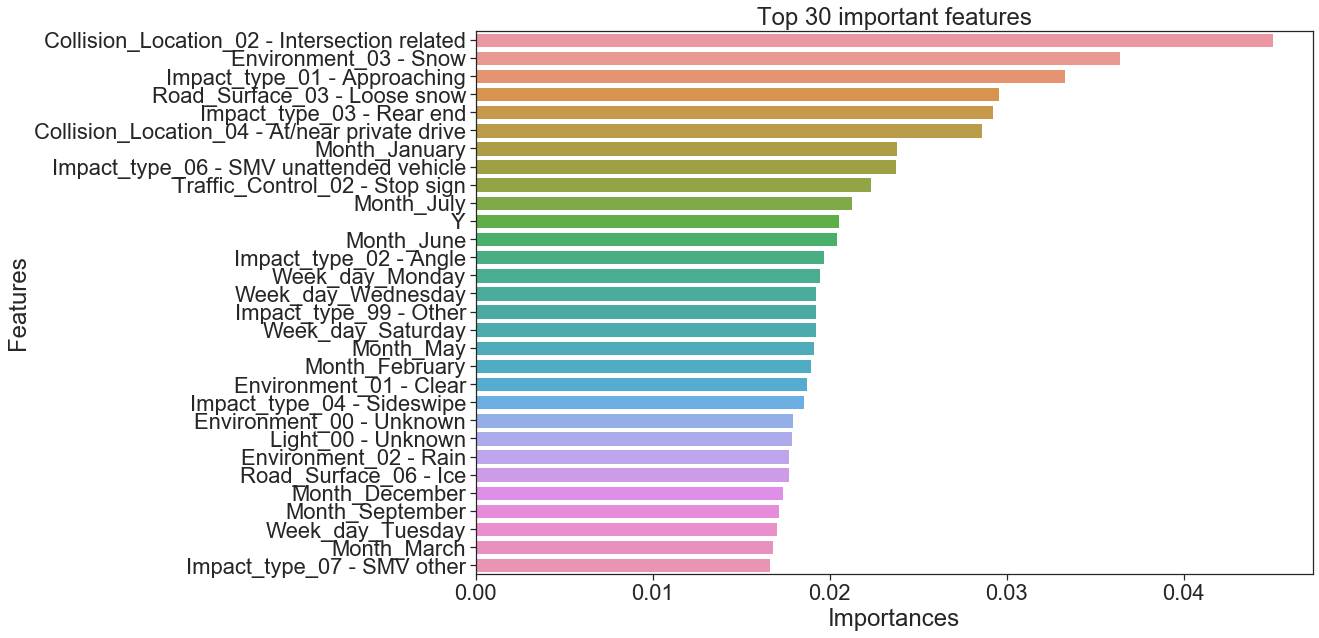

In [82]:
# Feature importance using XGBoost Classifier
best_xgb = rsearch_xgb.best_estimator_
features = X_train_prepared.columns

importances = best_xgb.feature_importances_
importance_df = pd.DataFrame({'Features': features, 'Importances': importances})
importance_df = importance_df.sort_values('Importances', ascending=False)

# Bar plot
plt.figure(figsize = (15,10))
sns.set(font_scale = 2)
sns.set_style('ticks')

sns.barplot(data = importance_df.head(30),  x = 'Importances', y = 'Features')
plt.title('Top 30 important features')

# Prediction on the Test Set
Let's make prediction on the test set using the best estimators from the randomized search

## 1. Logistic Regression

In [84]:
best_lr = gsearch_log.best_estimator_
Test_Prediction(best_lr, X_train_prepared, y_train_label, X_test_prepared, y_test_label)

****************************************************************************
Test accuracy:  0.803851
AUROC: 0.804808
AUPRC: 0.012161
Predicted classes: [0 1]
Confusion matrix:
 [[14049  3423]
 [   10    20]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89     17472
           1       0.01      0.67      0.01        30

    accuracy                           0.80     17502
   macro avg       0.50      0.74      0.45     17502
weighted avg       1.00      0.80      0.89     17502

****************************************************************************


## 2. Random Forest

In [85]:
best_rf = rsearch_rf.best_estimator_
Test_Prediction(best_rf, X_train_prepared, y_train_label, X_test_prepared, y_test_label)

****************************************************************************
Test accuracy:  0.998286
AUROC: 0.630989
AUPRC: 0.003653
Predicted classes: [0]
Confusion matrix:
 [[17472     0]
 [   30     0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     17472
           1       0.00      0.00      0.00        30

    accuracy                           1.00     17502
   macro avg       0.50      0.50      0.50     17502
weighted avg       1.00      1.00      1.00     17502

****************************************************************************


## 3. XGBoost

In [86]:
best_xgb = rsearch_xgb.best_estimator_
Test_Prediction(best_xgb, X_train_prepared, y_train_label, X_test_prepared, y_test_label)

****************************************************************************
Test accuracy:  0.980574
AUROC: 0.779029
AUPRC: 0.006237
Predicted classes: [0 1]
Confusion matrix:
 [[17161   311]
 [   29     1]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     17472
           1       0.00      0.03      0.01        30

    accuracy                           0.98     17502
   macro avg       0.50      0.51      0.50     17502
weighted avg       1.00      0.98      0.99     17502

****************************************************************************


# ROC  and PR Curves on the  Test set

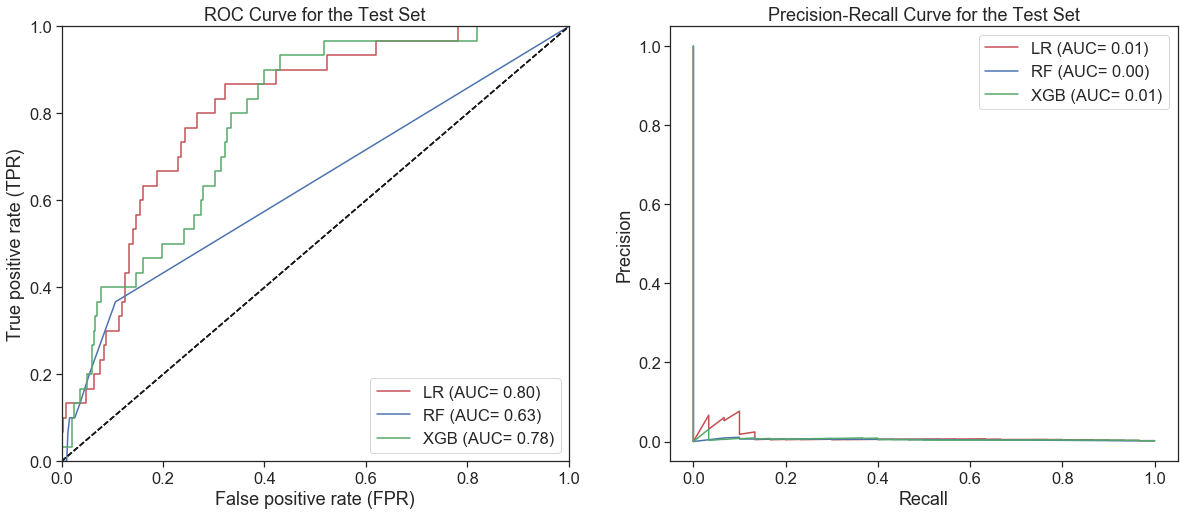

In [87]:
# Set figure and font sizes
fig = plt.figure(figsize = (20,8))
plt.rcParams.update({'font.size':20})
sns.set(font_scale = 1.5)
sns.set_style('ticks')

# Plot ROC and PR Curves for LR
Plot_ROC_Curve_and_PRC(best_lr, X_train_prepared, y_train_label, X_test_prepared, y_test_label,
                     color= 'r', label = 'LR (AUC= %0.2f)')

# Plot ROC and PR Curves for RF
Plot_ROC_Curve_and_PRC(best_rf, X_train_prepared, y_train_label, X_test_prepared, y_test_label,
                        color= 'b', label = 'RF (AUC= %0.2f)')

# Plot ROC and PR Curves for XGB
Plot_ROC_Curve_and_PRC(best_xgb, X_train_prepared, y_train_label, X_test_prepared, y_test_label,
                        color= 'g', label = 'XGB (AUC= %0.2f)')